In [1]:
import sys
sys.path.append('../mss')
import visreader as mvis
import mssmain as mss

In [2]:
path = '../example_data/ex_1.mzML'
scans = mss.get_scans(path) # read mzml into scans
mss.noise_removal(scans, 5000) #noise removal for 5000 baseline

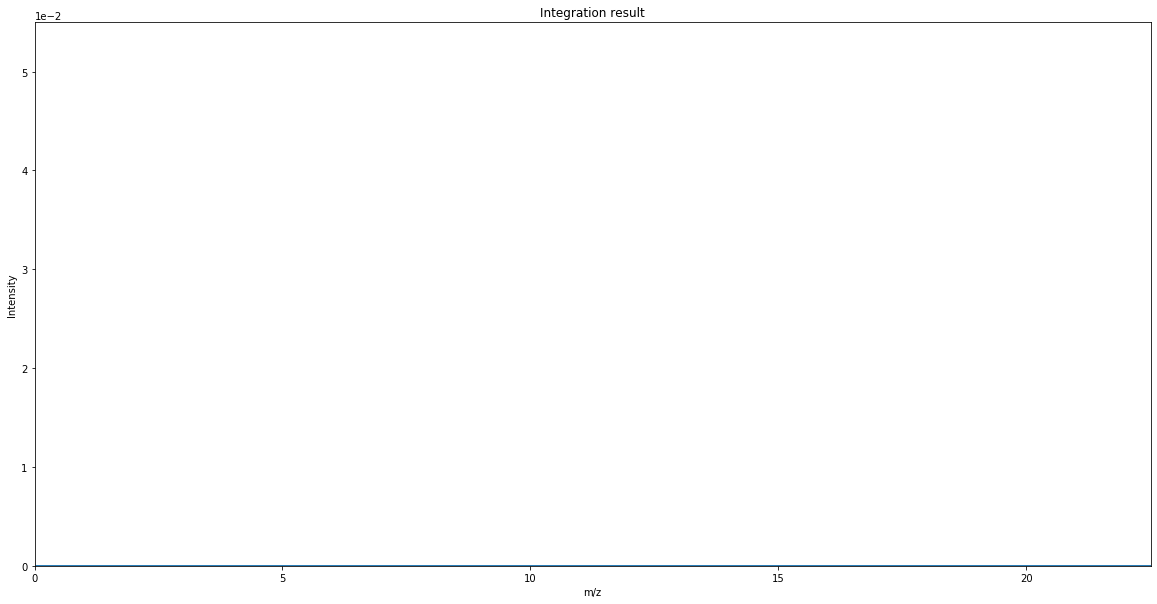

In [3]:
mvis.integration_plot(scans, 105.05, 0.02) #For the data visualization

In [40]:
def mz_locator(input_list, mz, error): #needs to refine, not use sum but use the closest mz
    '''
    Find specific mzs from given mz and error range out from a given mz array
    input list: mz list
    mz: input_mz that want to be found
    error: error range that can be bear as same mz, e.g, mz= 150, error = 0.2, then 148.8~150.2 == 150
    '''
    target_mz = []
    target_index = []
    
    error = error * 1e-6
    
    lower_mz = mz - error * mz
    higher_mz = mz + error * mz

    for i, mzs in enumerate(input_list):
        if mzs < lower_mz:
            continue
        elif mzs >= lower_mz:
            if mzs <= higher_mz:
                target_mz.append(mzs)
                target_index.append(i)
#         elif mzs > higher_mz:
#                 target_mz = 0
#                 target_index = 'NA'
#                 break
        
    return target_mz, target_index

In [44]:
target_mz, target_index = mz_locator(scans[500].mz, 500,20) #Please use 20ppm error as default setting

In [46]:
scans[500].scan_time

(2.803283333333, 'minute')

In [22]:
def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over whole rt period from the mzml file
        ***Most useful function!
        '''
        #Create empty list to store the data
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            #print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mz_locator(scan.mz, input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan.i[target_index]))
            
        return retention_time, intensity

In [24]:
rt, i =ms_chromatogram_list(scans, 299.5, 0.02)

In [ ]:
scans

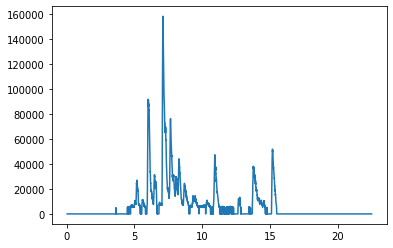

In [27]:
plt.plot(rt,i)

sample1
    mz 100 200 300
rt|i
1      1    0   5
2      2    0   10
3  ...
4
5
6
7
8

row stat1 stat2 stat3 y
                      peak/not peak-peak score

In [ ]:
#Deal with roi, check peakonly
def peak_pick(mzml_scans, input_mz, error, peak_base = 5000, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 15, max_scan = 200, max_peak = 5, min_scan_window = 20):
    '''
    firstly get rt, intensity from given mz and error out of the mzml file
    Then find peak on the intensity array, represent as index --> index
    Find peak range by looping from peak index forward/backward until hit the peak_base --> l_range,h_range. peakspan = h_range - l_range
    Trim/correct peak range is too small or too large, using min_scan/max_scan,min_scan_window --> trimed l/h_range
    Integration of peak based on the given range using simp function --> peakarea
    '''
    
    #Important funciont, may need to be extracted out later
    #Data output from the chromatogram_plot function
    def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over whole rt period from the mzml file
        ***Most useful function!
        '''
        #Create empty list to store the data
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            #print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mz_locator(scan.mz, input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan.i[target_index]))
            
        return retention_time, intensity
    
    rt, intensity = ms_chromatogram_list(mzml_scans, input_mz, error)
    
    #Get rt_window corresponded scan number
    scan_window = int((rt_window / (rt[int(len(intensity) / 2)] - rt[int(len(intensity) / 2) - 1])) / 2)
    
    #Get peak index
    indexes = peakutils.indexes(intensity, thres=thr, min_dist = min_d)
    
    result_dict = {}
    
    for index in indexes:
        h_range = index
        l_range = index
        base_intensity = peak_base

        #Get the higher and lower boundary
        while intensity[h_range] >= base_intensity:
            h_range += 1
            if h_range > len(intensity)-2:
                break
        while intensity[l_range] >= base_intensity:
            l_range -= 1
        #Output a range from the peak list
        
        peak_range = []
        if h_range - l_range >= min_scan:
            if rt[h_range] - rt[l_range] <= rt_window:
                peak_range = intensity[l_range:h_range]
            else:
                l_range = index - scan_window
                h_range = index + scan_window
                peak_range = intensity[l_range:h_range]
                #print(index + scan_window)

        #Intergration based on the simps function
        if len(peak_range) >= min_scan:
            integration_result = simps(peak_range)
            if integration_result >= peak_area_thres:
                if len(result_dict) == 0:
                    result_dict.update({index : [l_range, h_range, integration_result]})
                elif integration_result != list(result_dict.values())[-1][2]: #Compare with previous item
                    s_window = abs(index - list(result_dict.keys())[-1])
                    if s_window > min_scan_window:
                        result_dict.update({index : [l_range, h_range, integration_result]})
                    
                
        #Filtering:
        #1. delete results that l_range/h_range within 5 scans
        #3. If still >5 then select top 5 results
        #list(result_dict.values())[-1]
    
    #Noise filter
    if len(result_dict) > max_peak:
        result_dict = {}
        


    return result_dict